# Prototype for simple fits using gv_lsqfit
### Added functionality to choose fit function using fit_no



## Index:
* [Choosing the Fit function](#fit_func)
* [Fit1](# fit1)
* [Fit2](# fit2)


In [1]:

import numpy as np
import scipy as sp
import pandas as pd
import glob
import os

# Graphics
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import itertools


import lsqfit
import gvar as gv

# Code for neat formatting.
from IPython.display import display, HTML, Markdown
def printmd(string):
    display(Markdown(string))




### The functions used in fit and plot

In [2]:
# Functions for performing Fit and plot.

def f_make_p0(par):
    p0=par.copy()
    return p0

def f_make_prior(par):
    prior=par.copy()
    return prior    
    
def f_fit_plot(x,y,all_dta,fit,error_band=False,semilog=False,full_data=True):
    '''
    Function for plotting data with the fit lines and error bands.
    For correlators, using a semi-log plot.
    full_data=True, plots the entire data and the best-fit in the fit region
    '''

    plt.figure()
    # Plots data points
    if full_data: # Plot all the correlators even those not used in the fit.
        plt.errorbar(x=all_dta['x'],y=gv.mean(all_dta['y']),yerr=gv.sdev(all_dta['y']),color='black',linestyle='None',marker='o')
    else:         # Plot the data points used in the fit
        plt.errorbar(x=x['x'],y=gv.mean(y['y']),yerr=gv.sdev(y['y']),linestyle='None',color='red',marker='s')
    
    # Plot the best fit line
    # # Using a finer grid to get a continuous curve.
    curvex=dict(x)
    curvex['x']=np.linspace(min(fit.x['x']),max(fit.x['x']),500)
    curvey=gv.mean(fit.fcn(curvex,fit.p))
    plt.plot(curvex['x'],curvey,color='blue')

    if error_band:
        obs_fit=gv.mean(fit.fcn(curvex,fit.p))
        err_fit=gv.sdev(fit.fcn(curvex,fit.p))  
        sigma=2.0
        plt.fill_between(curvex['x'],obs_fit-sigma*err_fit,obs_fit+sigma*err_fit,color='yellow') # providing an error band.

    if semilog: plt.semilogy()
   
    plt.title("Plot")


def f_perform_fit(all_dta,x,y,verbose=True,plot=True,full_data=False,error_band=False,semilog=False):
    
    '''
    Function wrapper to perform correlator fit for mesons.
    Reads dictionary dta with x and y data.
    Performs both cosh and sinh fits.
    '''
    
    print "*****************************",'\n'
    # Performing meson fit
    
    p0=f_make_p0(par)
    fit = lsqfit.nonlinear_fit(data=(x, y['y']), fcn=f_func, p0=p0,extend=True,svdcut=1e-8)
    
    # Print the fit results
    if verbose: 
        print f_func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
        print(fit.format(maxline=True)),"\n\n"
    else :
        print fit,"\n\n"
    
    # Plot fit
    if plot: f_fit_plot(x,y,all_dta,fit,full_data=full_data,error_band=error_band,semilog=semilog)

    return fit


# Code to find outlier
def f_outlier_list(fit):
    ''' Code to find outliers in a fit
    Reads fit and returns list of indices of outliers.
    '''
    y_th=fit.fcn(fit.x,fit.p)
    y_exp=fit.y
    outlier_list=[]
    for i,(j,k) in enumerate(zip(y_exp,y_th)):
        # Find points with chi-square more than 3.
        if gv.chi2(j,k)>3.0:
            outlier_list.append(i)

    return outlier_list


<a id = 'fit_func'></a>
### Choosing the fit function

In [3]:
# Functions for fitting

def f_choose_fit(ft,param,verbose=False):  
    if ft==1: # defining powerlaw fit
        par_names=['a1','p1']
        fit_name='Powerlaw'
        def func(x,p):
            '''
            f(x)= a1 x^(p1)
            '''
            x=x['x']
            a1,p1=p['a1'],p['p1']
            
            ans= a1 * x**(p1)
            return ans

    elif ft==2: # defining 2-powerlaw fit
        par_names=['a1','p1','a2','p2']
        fit_name='Two-powerlaw'
        def func(x,p):
            '''
            f(x)= a1 x^(p1) + a2 x^(p2)
            '''
            x=x['x']
            a1,a2,p1,p2=p['a1'],p['a2'],p['p1'],p['p2']
            ans= a1 * x**(p1)+a2 * x**(p2)
            return ans  

    elif ft==3: # defining constant + power-law fit
        par_names=['a1','p1','a2']
        fit_name='Const+power'
        def func(x,p):
            '''
            f(x)= a1 L^(p1) + a2
            '''
            x=x['x']
            a1,a2,p1=p['a1'],p['a2'],p['p1']
            ans= a1 * x**(p1) + a2
            return ans      
 
    elif ft==4: # defining exponential fit
        par_names=['a1','p1']
        fit_name='Exponential'

        def func(x,p):
            '''
            f(x)= a1 e^(p1*x)
            '''
            x=x['x']
            a1,p1=p['a1'],p['p1']
            
            ans= a1 * np.exp(p1*x)
            return ans  

    elif ft==5: # defining constant + exponential fit
        par_names=['a1','p1','a2']
        fit_name='Const+exp'

        def func(x,p):
            '''
            f(x)= a1 e^(p1*x) + a2
            '''
            x=x['x']
            a1,a2,p1=p['a1'],p['a2'],p['p1']
            ans= a1 * np.exp(p1*x) + a2
            return ans   

    elif ft==6: # defining Peakfit
        par_names=['chi_p','Up','a1','a2','a3']
        fit_name='Peak-fit'
        
        def func(x,p):
            '''
            f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4
            '''
            x=x['x']
            a1,a2,a3=p['a1'],p['a2'],p['a3']
            chi_p,Up=p['chi_p'],p['Up']

            ans=chi_p + a1 *(x-Up)**2 + a2 *(x-Up)**3  + a3 *(x-Up)**4
            return ans

        
    elif ft==7: # defining inverse log
        par_names=['a1','a2']
        fit_name='Inv log'
        def func(x,p):
            '''
            f(x)= a1/(a2+np.log(x))
            '''
            x=x['x']
            a1,a2=p['a1'],p['a2']
            ans= a1/(a2+ np.log(x))
            return ans
        
    elif ft==8: # defining inverse log
        par_names=['a1','a2']
        fit_name='two power log'
        def func(x,p):
            '''
            f(x)= a1/(np.log(x)+a2/(np.log(x)**2
            '''
            x=x['x']
            a1,a2=p['a1'],p['a2']
            
            ans= a1/(np.log(x))+a2/((np.log(x))**2)

            return ans
    else:
        print "Invalid fit number"
        raise SystemError
    
    # Checking if the parameter list given is correct.
    chk=(set(par_names)== set(param.keys())) # Comparing parameter dictionary with par_names
    print chk
    if chk:
        if verbose: print func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
    else : # If parameter lists don't match, raise error.
        print "For function",func.__doc__.strip('\n').strip('  ')        
        print "Parameter list is wrong. Correct list is",par_names
        raise SystemError

    
    return func



## Data structures:
- all_dta : storing full data. Useful for plot.
- dta : storing data to fit. Dictionary {'x':,'y':gvar(val(err))}
- p0 : Initial parameter guess.

### Simple peak fit of data
<a id = ' fit1'></a>

[ 0.37  0.38  0.39  0.4   0.41  0.42  0.43] [ 3.23190025  3.31273137  3.35112978  3.37401413  3.34427884  3.29707684
  3.22748678] [ 0.00500566  0.00469461  0.0043059   0.00397634  0.00369756  0.00354921
  0.00340632]
True
f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4

***************************** 

f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4

Least Square Fit (no prior):
  chi2/dof [dof] = 2.1 [2]    Q = 0.12    logGBF = None

Parameters:
             a1        390 (35)      [    1 +- inf ]  
             a3   20747 (19131)      [ 0.04 +- inf ]  
             a2    -5603 (2647)      [    1 +- inf ]  
             Up      0.326 (37)      [  0.4 +- inf ]  
          chi_p       2.88 (49)      [    1 +- inf ]  

Fit:
      key         y[key]      f(p)[key]
---------------------------------------
        0    3.2319 (50)    3.2326 (50)  
        1    3.3127 (47)    3.3097 (40)  
        2    3.3511 (43)    3.3566 (29)  *
        3    3.3740 (40)    3.3689 (30)  *


<IPython.core.display.Javascript object>


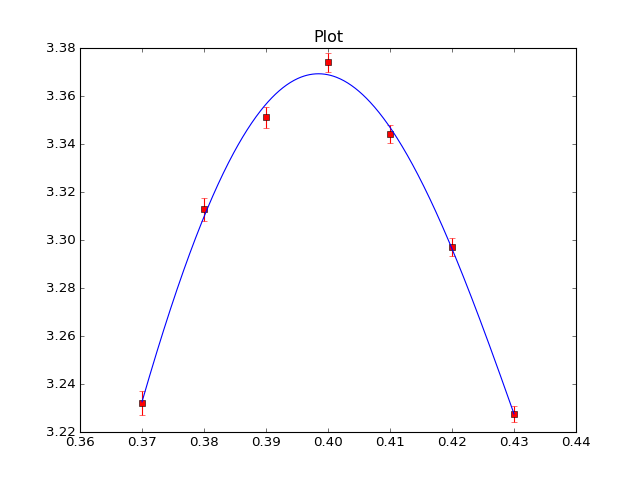

In [4]:

if __name__ == '__main__': 
    # Extract data from file.
    data_dir='test_data/'
    df2=pd.read_csv(data_dir+'SUS_1',sep='\t',names=['U','L','sus','dsus']).reset_index().drop('index',1)
    
    # Trim data
    df3=df2[df2.L==32][['U','sus','dsus']]
    all_dta={'x':df3.U.values,'y':gv.gvar(df3.sus.values,df3.dsus.values)}

    df=df3[(df3.U>0.35) & (df3.U<0.44)]
    dta=df.as_matrix().astype(np.float64)[1:]
    xdata,ydata,yerr=dta[:,0],dta[:,1],dta[:,2]
    print xdata,ydata,yerr
    
### Actual fitting of data.
if __name__ == '__main__': 
    x,y={'x':xdata},{'y':gv.gvar(ydata,yerr)}
    # Initial guesses for parameters.
    par={'chi_p':1,'Up':0.4,'a1':1,'a2':1,'a3':0.04}
    f_func=f_choose_fit(ft=6,param=par,verbose=True) # choosing fit function for evaulation

    fit=f_perform_fit(all_dta,x,y,verbose=True,plot=True,full_data=False,error_band=False)


In [5]:
print f_outlier_list(fit)
df.iloc[f_outlier_list(fit),:]


[3]


,U,sus,dsus
21,0.39,3.35113,0.004306


------------------------
--------------------------------

## Log fit to peak data
<a id = ' fit2'></a>

In [6]:
## Extract data into structures.

if __name__ == '__main__':
    data_dir='test_data/'
    df_best_chosen_peak_fit_results=pd.read_csv(data_dir+'chosen_sus1_df.csv')
    df=df_best_chosen_peak_fit_results.copy()
    dta= df[['L','Up','dUp']].as_matrix().astype(np.float64)[1:]
    xdata,ydata,yerr=dta[:,0],dta[:,1],dta[:,2]
    print xdata,ydata,yerr



[  32.   64.  128.  256.] [ 0.398  0.33   0.283  0.242] [ 0.002  0.003  0.003  0.004]


True
f(x)= a1/(np.log(x)+a2/(np.log(x)**2

***************************** 

f(x)= a1/(np.log(x)+a2/(np.log(x)**2

Least Square Fit (no prior):
  chi2/dof [dof] = 0.51 [2]    Q = 0.6    logGBF = None

Parameters:
             a1   1.325 (39)     [   1 +- inf ]  
             a2    0.19 (15)     [ 0.1 +- inf ]  

Fit:
      key         y[key]      f(p)[key]
---------------------------------------
        0    0.3980 (20)    0.3982 (19)  
        1    0.3300 (30)    0.3296 (15)  
        2    0.2830 (30)    0.2812 (20)  
        3    0.2420 (40)    0.2452 (24)  

Settings:
  svdcut/n = 1e-08/0    reltol/abstol = 0.0001/0    (itns/time = 2/0.0)





<IPython.core.display.Javascript object>


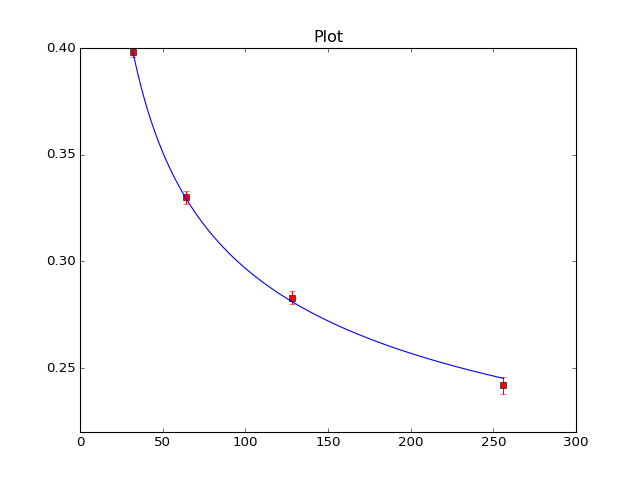

In [7]:
if __name__ == '__main__':
    x,y={'x':xdata},{'y':gv.gvar(ydata,yerr)}
    # Initial guesses for parameters.
    par={'a1':1,'a2':0.1}
    # Choose the fit function.
    f_func=f_choose_fit(ft=8,param=par,verbose=True) # choosing fit function for evaulation
    fit=f_perform_fit(all_dta,x,y,verbose=True,plot=True,full_data=False,error_band=False)


### Things to do:
- Way to add prior.

In [8]:
print f_outlier_list(fit)
df.iloc[f_outlier_list(fit),:]


[]


,L,chi_p,dchi_p,Up,dUp
